<a href="https://colab.research.google.com/github/Pranav-Bhatlapenumarthi/Deep_Learning/blob/main/NN_Optimisers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm # to show progression bar
import random

import torch
import torch.nn as nn
import torch.optim as optim


import torch.nn.functional as F # provides functions that are used in building NN layers
from torch.utils.data import DataLoader # helps load data in batches
from torchvision import datasets, transforms # used to access datasets and applying necessary transformatations to images

#!pip install torchmetrics
import torchmetrics # provides performance metrics for model evaluation

In [7]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
batch_size = 100

train_dataset = datasets.MNIST(root='datasets/', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='datasets/', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [15]:
model = CNN(input_channels=1, classify_categories=10).to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train_one_epoch(model, loader, optimizer, criterion):
  model.train() #Switches to training mode.
  total_loss = 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad() # clears old gradients as PyTorch accumulates gradients by default
    out = model(x)
    loss = criterion(out, y)
    loss.backward() # computes gradients via backpropagation
    optimizer.step() # updates model parameters

    total_loss += loss.item()

  return total_loss / len(loader) # Returns mean training loss per batch for the epoch as a monitoring metric



In [18]:
def evaluate(model, loader, criterion):
    model.eval() # Switches to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): # Disables gradient tracking
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            preds = out.argmax(dim=1) # Converts logits to the predicted class
            correct += (preds == y).sum().item() # Computes classification accuracy
            total += y.size(0)

    return total_loss / len(loader), correct / total # returns average validation loss and validation accuracy


In [21]:
def get_optimizer(name, model):
    if name == "SGD":
        return optim.SGD(model.parameters(), lr=0.01)
    if name == "SGD_Momentum":
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    if name == "Adam":
        return optim.Adam(model.parameters(), lr=0.001)
    if name == "RMSprop":
        return optim.RMSprop(model.parameters(), lr=0.001)
    if name == "AdamW":
        return optim.AdamW(model.parameters(), lr=0.001)

In [22]:
criterion = nn.CrossEntropyLoss()
epochs = 10

optimizers = ["SGD", "SGD_Momentum", "Adam", "RMSprop", "AdamW"]
results = {}

for opt_name in optimizers: # loop defines one independent experiment per optimizer
    print(f"\nRunning optimizer: {opt_name}")
    set_seed()  # reset seed for every optimiser training to avoid comparision contamination
    model = SimpleCNN().to(device)
    optimizer = get_optimizer(opt_name, model)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, test_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, "
              f"Val Loss={val_loss:.4f}, "
              f"Val Acc={val_acc:.4f}")

    results[opt_name] = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "val_acc": val_accuracies
    }



Running optimizer: SGD
Epoch 1: Train Loss=1.1356, Val Loss=0.3536, Val Acc=0.8998
Epoch 2: Train Loss=0.3105, Val Loss=0.2331, Val Acc=0.9298
Epoch 3: Train Loss=0.2165, Val Loss=0.1667, Val Acc=0.9484
Epoch 4: Train Loss=0.1612, Val Loss=0.1361, Val Acc=0.9577
Epoch 5: Train Loss=0.1270, Val Loss=0.1315, Val Acc=0.9583
Epoch 6: Train Loss=0.1049, Val Loss=0.0902, Val Acc=0.9728
Epoch 7: Train Loss=0.0910, Val Loss=0.0734, Val Acc=0.9765
Epoch 8: Train Loss=0.0804, Val Loss=0.0662, Val Acc=0.9794
Epoch 9: Train Loss=0.0732, Val Loss=0.0716, Val Acc=0.9763
Epoch 10: Train Loss=0.0663, Val Loss=0.0609, Val Acc=0.9813

Running optimizer: SGD_Momentum
Epoch 1: Train Loss=0.3378, Val Loss=0.1117, Val Acc=0.9633
Epoch 2: Train Loss=0.0724, Val Loss=0.0581, Val Acc=0.9808
Epoch 3: Train Loss=0.0498, Val Loss=0.0358, Val Acc=0.9882
Epoch 4: Train Loss=0.0373, Val Loss=0.0383, Val Acc=0.9876
Epoch 5: Train Loss=0.0302, Val Loss=0.0287, Val Acc=0.9905
Epoch 6: Train Loss=0.0259, Val Loss=0.032

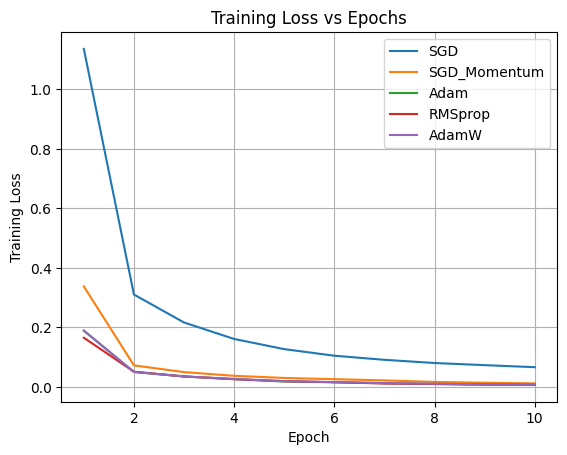

In [23]:
plt.figure()

for opt_name, metrics in results.items():
    plt.plot(
        range(1, len(metrics["train_loss"]) + 1),
        metrics["train_loss"],
        label=opt_name
    )

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


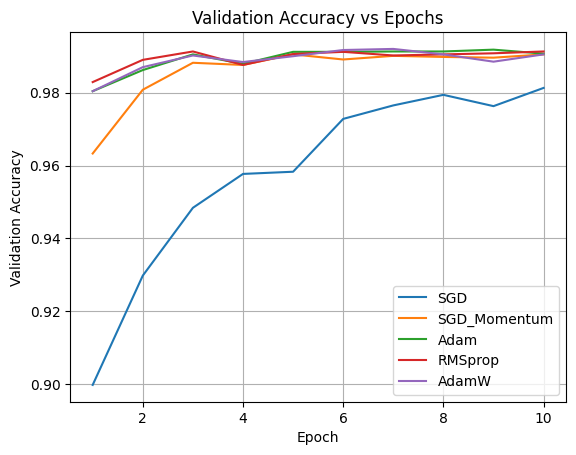

In [24]:
plt.figure()

for opt_name, metrics in results.items():
    plt.plot(
        range(1, len(metrics["val_acc"]) + 1),
        metrics["val_acc"],
        label=opt_name
    )

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()
